In [ ]:
# This information helps with debugging and getting support :)
import sys, platform
import pandas as pd
import bifacial_radiance as br
print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("bifacial_radiance version ", br.__version__)

# 12 - AgriPV Clearance Height Evaluation

This journal is based on Journal 11, now looping through various clearance-heights of the modules to evaluate ground irradiance and bifacial gain.


![AgriPV Bifacial Clearance Height Study](../images_wiki/AdvancedJournals/AgriPV_CHStudy.PNG)


<a id='step1'></a>

In [1]:
import os
from pathlib import Path

testfolder = str(Path().resolve().parent.parent / 'bifacial_radiance' / 'TEMP' / 'Tutorial_12')
if not os.path.exists(testfolder):
    os.makedirs(testfolder)
    
print ("Your simulation will be stored in %s" % testfolder)

Your simulation will be stored in C:\Users\mprillim\sam_dev\bifacial_radiance\bifacial_radiance\TEMP\Tutorial_12


In [2]:
from bifacial_radiance import *   
import numpy as np
import datetime

In [3]:
startdt_tomato =datetime.datetime(2001,3,15,0)
enddt_tomato = datetime.datetime(2001,6,30,23)
startdt_kale = datetime.datetime(2001,9,15,0)
enddt_kale = datetime.datetime(2001,10,31,23)
startdt_PV = datetime.datetime(2001,1,1,0)
enddt_PV = datetime.datetime(2001,12,31,23)

In [4]:
hub_heights = [4.3, 3.5, 2.5, 1.5]
albedo = 0.2  #'grass'     # ground albedo
crops = ['tomato', 'kale']

# Redundant. Overwritihng the Radiance Obj for each loop below to have a unique name.
demo = RadianceObj('tutorial_12', path=testfolder)  # Create a RadianceObj 'object'
demo.setGround(albedo) # input albedo number or material name like 'concrete'.  To see options, run this without any input.
lat = 32.22  # Tucson, AZ
lon = -110.97  # Tucson, Az 32.2226° N, 110.9747° W
epwfile = demo.getEPW(lat, lon) # NJ lat/lon 40.0583° N, 74.4057

path = C:\Users\mprillim\sam_dev\bifacial_radiance\bifacial_radiance\TEMP\Tutorial_12
Loading albedo, 1 value(s), 0.200 avg
1 nonzero albedo values.
Getting weather file: USA_AZ_Tucson.Intl.AP.722740_TMY3.epw
 ... OK!


## 1. Loop over the different heights

In [5]:
for jj in range (0, len(hub_heights)):
    hub_height = hub_heights[jj]
    simulationname = 'height_'+ str(int(hub_height*100))+'cm'

    #Location:
    # MakeModule Parameters
    moduletype='test-module'
    numpanels = 3  # AgriPV site has 3 modules along the y direction (N-S since we are facing it to the south) .
    x = 0.95  
    y = 1.95
    xgap = 2.0# Leaving 15 centimeters between modules on x direction
    ygap = 0.10 # Leaving 10 centimeters between modules on y direction
    zgap = 0 # no gap to torquetube.
    sensorsy = 6*numpanels  # this will give 6 sensors per module, 1 per cell

    # Other default values:

    # TorqueTube Parameters
    axisofrotationTorqueTube=False
    torqueTube = False
    cellLevelModule = True

    numcellsx = 12
    numcellsy = 6
    xcell = 0.156
    ycell = 0.156
    xcellgap = 0.02
    ycellgap = 0.02

    cellLevelModuleParams = {'numcellsx': numcellsx, 'numcellsy':numcellsy, 
                             'xcell': xcell, 'ycell': ycell, 'xcellgap': xcellgap, 'ycellgap': ycellgap}

    # SceneDict Parameters
    pitch = 15 # m
    torquetube_height = hub_height - 0.1 # m
    nMods = 6 # six modules per row.
    nRows = 3  # 3 row

    azimuth_ang=180 # Facing south
    tilt =35 # tilt. 

    # Now let's run the example
    demo = RadianceObj(simulationname,path = testfolder)  # Create a RadianceObj 'object'
    demo.setGround(albedo) # input albedo number or material name like 'concrete'.  To see options, run this without any input.

    #demo.gendaylit(4020)  # Use this to simulate only one hour at a time. 
    # Making module with all the variables
    module = demo.makeModule(name=moduletype, x=x, y=y, numpanels=numpanels, 
                               xgap=xgap, ygap=ygap, cellModule=cellLevelModuleParams)
    # create a scene with all the variables
    sceneDict = {'tilt':tilt, 'pitch':15, 'hub_height':hub_height, 'azimuth':azimuth_ang, 'nMods':nMods, 'nRows':nRows}  
    scene = demo.makeScene(module=moduletype, sceneDict=sceneDict) #makeScene creates a .rad file with 20 modules per row, 7 rows.
    octfile = demo.makeOct(demo.getfilelist())  # makeOct combines all of the ground, sky and object fil|es into a .oct file.

    torquetubelength = module.scenex*(nMods) 

    # torquetube 1
    name='Post1'
    text='! genbox Metal_Aluminum_Anodized torquetube_row1 {} 0.2 0.3 | xform -t {} -0.1 -0.3 | xform -t 0 0 {}'.format(torquetubelength, (-torquetubelength+module.sceney)/2.0, torquetube_height)
    customObject = demo.makeCustomObject(name,text)
    demo.appendtoScene(radfile=scene.radfiles, customObject=customObject, text="!xform -rz 0")

    name='Post2'
    text='! genbox Metal_Aluminum_Anodized torquetube_row2 {} 0.2 0.3 | xform -t {} -0.1 -0.3 | xform -t 0 15 {}'.format(torquetubelength, (-torquetubelength+module.sceney)/2.0, torquetube_height)
    customObject = demo.makeCustomObject(name,text)
    demo.appendtoScene(radfile=scene.radfiles, customObject=customObject, text="!xform -rz 0")

    name='Post3'
    text='! genbox Metal_Aluminum_Anodized torquetube_row2 {} 0.2 0.3 | xform -t {} -0.1 -0.3 | xform -t 0 -15 {}'.format(torquetubelength, (-torquetubelength+module.sceney)/2.0, torquetube_height)
    customObject = demo.makeCustomObject(name,text)
    demo.appendtoScene(radfile=scene.radfiles, customObject=customObject, text="!xform -rz 0")

    name='Pile'
    pile1x = (torquetubelength+module.sceney)/2.0
    pilesep = pile1x*2.0/7.0
    #! genrev Metal_Grey tube1 t*1.004 0.05 32 | xform -ry 90 -t -0.502 0 0
    text= '! genrev Metal_Grey tube1row1 t*{} 0.15 32 | xform -t {} 0 0'.format(torquetube_height, pile1x)
    text += '\r\n! genrev Metal_Grey tube1row2 t*{} 0.15 32 | xform -t {} 15 0'.format(torquetube_height, pile1x)
    text += '\r\n! genrev Metal_Grey tube1row3 t*{} 0.15 32 | xform -t {} -15 0'.format(torquetube_height, pile1x)

    for i in range (1, 7):
        text += '\r\n! genrev Metal_Grey tube{}row1 t*{} 0.15 32 | xform -t {} 0 0'.format(i+1, torquetube_height, pile1x-pilesep*i)
        text += '\r\n! genrev Metal_Grey tube{}row2 t*{} 0.15 32 | xform -t {} 15 0'.format(i+1, torquetube_height, pile1x-pilesep*i)
        text += '\r\n! genrev Metal_Grey tube{}row3 t*{} 0.15 32 | xform -t {} -15 0'.format(i+1, torquetube_height, pile1x-pilesep*i)

    customObject = demo.makeCustomObject(name,text)
    demo.appendtoScene(radfile=scene.radfiles, customObject=customObject, text="!xform -rz 0")


    for zz in range (0, len(crops)):
        crop = crops[zz]
        if crop == 'tomato':
            #startdt =datetime.datetime(2001,3,15,0)
            #enddt = datetime.datetime(2001,6,30,23)
            starttime = '2001-03-15_0100' 
            endtime = '2001-06-30_2300'
            print('PLANTING TOMATO')

        if crop == 'kale':
#            startdt = datetime.datetime(2001,9,15,0)
#            enddt = datetime.datetime(2001,10,31,23)
            starttime = '2001-09-15_0100' 
            endtime = '2001-10-31_2300'
            print('PLANTING KALE')
        
        metdata = demo.readWeatherFile(epwfile, starttime=starttime, endtime=endtime, coerce_year=2001) # read in the EPW weather data from above
        demo.genCumSky(savefile=crop)

        octfile = demo.makeOct()  # makeOct combines all of the ground, sky and object files into a .oct file.

        analysis = AnalysisObj(octfile, demo.name)  # return an analysis object including the scan dimensions for back irradiance
        sensorsy = 30
        sensorsx = 30
        startgroundsample=-module.scenex
        spacingbetweensamples = module.scenex/(sensorsx-1)

        for i in range (0, sensorsx):  
            frontscan, backscan = analysis.moduleAnalysis(scene, sensorsy=sensorsy)
            groundscan = frontscan
            groundscan['zstart'] = 0.05  # setting it 5 cm from the ground.
            groundscan['zinc'] = 0   # no tilt necessary. 
            groundscan['yinc'] = pitch/(sensorsy-1)   # increasing spacing so it covers all distance between rows
            groundscan['xstart'] = startgroundsample + i*spacingbetweensamples   # increasing spacing so it covers all distance between rows
            analysis.analysis(octfile, simulationname+'_'+crop+'_'+str(i), groundscan, backscan)  # compare the back vs front irradiance  

    metdata = demo.readWeatherFile(epwfile) # read in the EPW weather data from above
    demo.genCumSky(savefile = 'PV')#startdt=startdt, enddt=enddt)

    octfile = demo.makeOct()  # makeOct combines all of the ground, sky and object files into a .oct file.

    analysis = AnalysisObj(octfile, demo.name)  # return an analysis object including the scan dimensions for back irradiance
    sensorsy = 20
    sensorsx = 12
    startPVsample=-module.x
    spacingbetweenPVsamples = module.x/(sensorsx-1)

    for i in range (0, sensorsx): # Will map 20 points    
        frontscan, backscan = analysis.moduleAnalysis(scene, sensorsy=sensorsy)
        frontscan['xstart'] = startPVsample + i*spacingbetweenPVsamples   # increasing spacing so it covers all distance between rows
        analysis.analysis(octfile, simulationname+'_PV_'+str(i), frontscan, backscan)  # compare the back vs front irradiance  


path = C:\Users\mprillim\sam_dev\bifacial_radiance\bifacial_radiance\TEMP\Tutorial_12
Loading albedo, 1 value(s), 0.200 avg
1 nonzero albedo values.

Module Name: test-module
Module was shifted by 0.078 in X to avoid sensors on air
This is a Cell-Level detailed module with Packaging Factor of 0.81 %
Module test-module updated in module.json
Pre-existing .rad file objects\test-module.rad will be overwritten

Created height_430cm.oct

Custom Object Name objects\Post1.rad

Custom Object Name objects\Post2.rad

Custom Object Name objects\Post3.rad

Custom Object Name objects\Pile.rad
PLANTING TOMATO
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2001
Filtering dates
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Loaded  EPWs\metdata_temp.csv
mess

Linescan in process: height_350cm_tomato_11_Back
Saved: results\irr_height_350cm_tomato_11.csv
Linescan in process: height_350cm_tomato_12_Front
Linescan in process: height_350cm_tomato_12_Back
Saved: results\irr_height_350cm_tomato_12.csv
Linescan in process: height_350cm_tomato_13_Front
Linescan in process: height_350cm_tomato_13_Back
Saved: results\irr_height_350cm_tomato_13.csv
Linescan in process: height_350cm_tomato_14_Front
Linescan in process: height_350cm_tomato_14_Back
Saved: results\irr_height_350cm_tomato_14.csv
Linescan in process: height_350cm_tomato_15_Front
Linescan in process: height_350cm_tomato_15_Back
Saved: results\irr_height_350cm_tomato_15.csv
Linescan in process: height_350cm_tomato_16_Front
Linescan in process: height_350cm_tomato_16_Back
Saved: results\irr_height_350cm_tomato_16.csv
Linescan in process: height_350cm_tomato_17_Front
Linescan in process: height_350cm_tomato_17_Back
Saved: results\irr_height_350cm_tomato_17.csv
Linescan in process: height_350cm_t

Saved: results\irr_height_350cm_kale_24.csv
Linescan in process: height_350cm_kale_25_Front
Linescan in process: height_350cm_kale_25_Back
Saved: results\irr_height_350cm_kale_25.csv
Linescan in process: height_350cm_kale_26_Front
Linescan in process: height_350cm_kale_26_Back
Saved: results\irr_height_350cm_kale_26.csv
Linescan in process: height_350cm_kale_27_Front
Linescan in process: height_350cm_kale_27_Back
Saved: results\irr_height_350cm_kale_27.csv
Linescan in process: height_350cm_kale_28_Front
Linescan in process: height_350cm_kale_28_Back
Saved: results\irr_height_350cm_kale_28.csv
Linescan in process: height_350cm_kale_29_Front
Linescan in process: height_350cm_kale_29_Back
Saved: results\irr_height_350cm_kale_29.csv
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position

Created height_350cm.oct
Linescan in process: height_350cm_PV_0_Front
Linescan in process: height_350cm_PV_0_Back
Saved: results\irr_height_350cm_PV_0.csv
Linescan in process: height_350cm_PV_1_Front
Linescan in process: height_350cm_PV_1_Back
Saved: results\irr_height_350cm_PV_1.csv
Linescan in process: height_350cm_PV_2_Front
Linescan in process: height_350cm_PV_2_Back
Saved: results\irr_height_350cm_PV_2.csv
Linescan in process: height_350cm_PV_3_Front
Linescan in process: height_350cm_PV_3_Back
Saved: results\irr_height_350cm_PV_3.csv
Linescan in process: height_350cm_PV_4_Front
Linescan in process: height_350cm_PV_4_Back
Saved: results\irr_height_350cm_PV_4.csv
Linescan in process: height_350cm_PV_5_Front
Linescan in process: height_350cm_PV_5_Back
Saved: results\irr_height_350cm_PV_5.csv
Linescan in process: height_350cm_PV_6_Front
Linescan in process: height_350cm_PV_6_Back
Saved: results\irr_height_350cm_PV_6.csv
Linescan in process: height_350cm_PV_7_Front
Linescan in process:

Linescan in process: height_250cm_tomato_11_Back
Saved: results\irr_height_250cm_tomato_11.csv
Linescan in process: height_250cm_tomato_12_Front
Linescan in process: height_250cm_tomato_12_Back
Saved: results\irr_height_250cm_tomato_12.csv
Linescan in process: height_250cm_tomato_13_Front
Linescan in process: height_250cm_tomato_13_Back
Saved: results\irr_height_250cm_tomato_13.csv
Linescan in process: height_250cm_tomato_14_Front
Linescan in process: height_250cm_tomato_14_Back
Saved: results\irr_height_250cm_tomato_14.csv
Linescan in process: height_250cm_tomato_15_Front
Linescan in process: height_250cm_tomato_15_Back
Saved: results\irr_height_250cm_tomato_15.csv
Linescan in process: height_250cm_tomato_16_Front
Linescan in process: height_250cm_tomato_16_Back
Saved: results\irr_height_250cm_tomato_16.csv
Linescan in process: height_250cm_tomato_17_Front
Linescan in process: height_250cm_tomato_17_Back
Saved: results\irr_height_250cm_tomato_17.csv
Linescan in process: height_250cm_t

Saved: results\irr_height_250cm_kale_24.csv
Linescan in process: height_250cm_kale_25_Front
Linescan in process: height_250cm_kale_25_Back
Saved: results\irr_height_250cm_kale_25.csv
Linescan in process: height_250cm_kale_26_Front
Linescan in process: height_250cm_kale_26_Back
Saved: results\irr_height_250cm_kale_26.csv
Linescan in process: height_250cm_kale_27_Front
Linescan in process: height_250cm_kale_27_Back
Saved: results\irr_height_250cm_kale_27.csv
Linescan in process: height_250cm_kale_28_Front
Linescan in process: height_250cm_kale_28_Back
Saved: results\irr_height_250cm_kale_28.csv
Linescan in process: height_250cm_kale_29_Front
Linescan in process: height_250cm_kale_29_Back
Saved: results\irr_height_250cm_kale_29.csv
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position

Created height_250cm.oct
Linescan in process: height_250cm_PV_0_Front
Linescan in process: height_250cm_PV_0_Back
Saved: results\irr_height_250cm_PV_0.csv
Linescan in process: height_250cm_PV_1_Front
Linescan in process: height_250cm_PV_1_Back
Saved: results\irr_height_250cm_PV_1.csv
Linescan in process: height_250cm_PV_2_Front
Linescan in process: height_250cm_PV_2_Back
Saved: results\irr_height_250cm_PV_2.csv
Linescan in process: height_250cm_PV_3_Front
Linescan in process: height_250cm_PV_3_Back
Saved: results\irr_height_250cm_PV_3.csv
Linescan in process: height_250cm_PV_4_Front
Linescan in process: height_250cm_PV_4_Back
Saved: results\irr_height_250cm_PV_4.csv
Linescan in process: height_250cm_PV_5_Front
Linescan in process: height_250cm_PV_5_Back
Saved: results\irr_height_250cm_PV_5.csv
Linescan in process: height_250cm_PV_6_Front
Linescan in process: height_250cm_PV_6_Back
Saved: results\irr_height_250cm_PV_6.csv
Linescan in process: height_250cm_PV_7_Front
Linescan in process:

Linescan in process: height_150cm_tomato_11_Back
Saved: results\irr_height_150cm_tomato_11.csv
Linescan in process: height_150cm_tomato_12_Front
Linescan in process: height_150cm_tomato_12_Back
Saved: results\irr_height_150cm_tomato_12.csv
Linescan in process: height_150cm_tomato_13_Front
Linescan in process: height_150cm_tomato_13_Back
Saved: results\irr_height_150cm_tomato_13.csv
Linescan in process: height_150cm_tomato_14_Front
Linescan in process: height_150cm_tomato_14_Back
Saved: results\irr_height_150cm_tomato_14.csv
Linescan in process: height_150cm_tomato_15_Front
Linescan in process: height_150cm_tomato_15_Back
Saved: results\irr_height_150cm_tomato_15.csv
Linescan in process: height_150cm_tomato_16_Front
Linescan in process: height_150cm_tomato_16_Back
Saved: results\irr_height_150cm_tomato_16.csv
Linescan in process: height_150cm_tomato_17_Front
Linescan in process: height_150cm_tomato_17_Back
Saved: results\irr_height_150cm_tomato_17.csv
Linescan in process: height_150cm_t

Saved: results\irr_height_150cm_kale_24.csv
Linescan in process: height_150cm_kale_25_Front
Linescan in process: height_150cm_kale_25_Back
Saved: results\irr_height_150cm_kale_25.csv
Linescan in process: height_150cm_kale_26_Front
Linescan in process: height_150cm_kale_26_Back
Saved: results\irr_height_150cm_kale_26.csv
Linescan in process: height_150cm_kale_27_Front
Linescan in process: height_150cm_kale_27_Back
Saved: results\irr_height_150cm_kale_27.csv
Linescan in process: height_150cm_kale_28_Front
Linescan in process: height_150cm_kale_28_Back
Saved: results\irr_height_150cm_kale_28.csv
Linescan in process: height_150cm_kale_29_Front
Linescan in process: height_150cm_kale_29_Back
Saved: results\irr_height_150cm_kale_29.csv
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position

Created height_150cm.oct
Linescan in process: height_150cm_PV_0_Front
Linescan in process: height_150cm_PV_0_Back
Saved: results\irr_height_150cm_PV_0.csv
Linescan in process: height_150cm_PV_1_Front
Linescan in process: height_150cm_PV_1_Back
Saved: results\irr_height_150cm_PV_1.csv
Linescan in process: height_150cm_PV_2_Front
Linescan in process: height_150cm_PV_2_Back
Saved: results\irr_height_150cm_PV_2.csv
Linescan in process: height_150cm_PV_3_Front
Linescan in process: height_150cm_PV_3_Back
Saved: results\irr_height_150cm_PV_3.csv
Linescan in process: height_150cm_PV_4_Front
Linescan in process: height_150cm_PV_4_Back
Saved: results\irr_height_150cm_PV_4.csv
Linescan in process: height_150cm_PV_5_Front
Linescan in process: height_150cm_PV_5_Back
Saved: results\irr_height_150cm_PV_5.csv
Linescan in process: height_150cm_PV_6_Front
Linescan in process: height_150cm_PV_6_Back
Saved: results\irr_height_150cm_PV_6.csv
Linescan in process: height_150cm_PV_7_Front
Linescan in process:

## 2. Plot Bifacial Gain Results

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [7]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

sns.set(rc={'figure.figsize':(11.7,8.27)})

Text(0.5, 0, 'Hub height [m]')

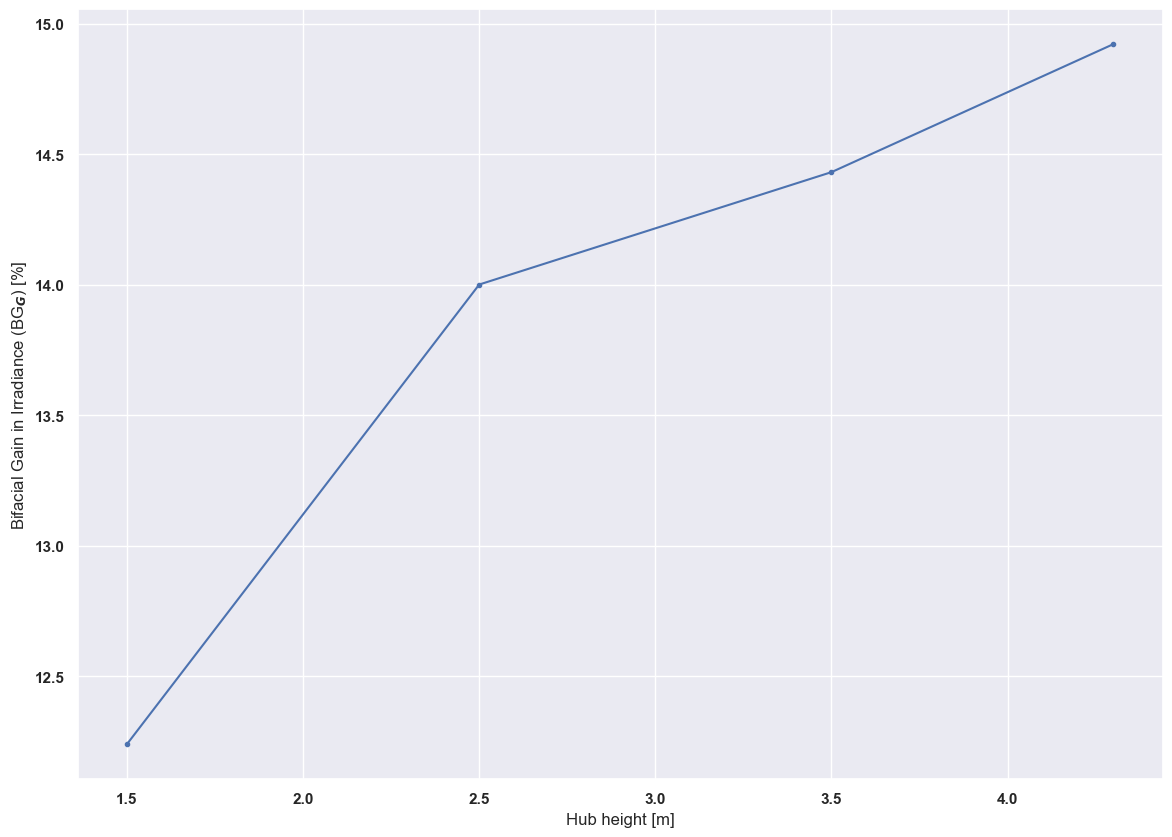

In [8]:
hub_heights = [4.3, 3.5, 2.5, 1.5]
results_BGG=[]
for i in range(0, len(hub_heights)):
    hub_height = str(int(hub_heights[i]*100))
    filepv= os.path.join(testfolder,'results',f'irr_height_{hub_height}cm_PV_6.csv')
    resultsDF = load.read1Result(filepv)
    resultsDF = load.cleanResult(resultsDF).dropna()
    results_BGG.append(resultsDF['Wm2Back'].sum()*100/resultsDF['Wm2Front'].sum())
    
plt.figure(figsize=(14,10))
plt.plot(hub_heights, results_BGG, '.-')
plt.ylabel('Bifacial Gain in Irradiance (BG$_G$) [%]')
plt.xlabel('Hub height [m]')

## 3. Plot Heatmaps of the Ground Irradiance

First, here is a complicated way to find the maximum of all arrays so all heatmaps are referenced to that value

In [9]:
maxmax = 0
for hh in range (0, len(hub_heights)):
    for cc in range (0, len(crops)):
        filestarter = "irr_height_"+ str(int(hub_heights[hh]*100))+'cm_'+crops[cc]

        filelist = sorted(os.listdir(os.path.join(testfolder, 'results')))
        prefixed = [filename for filename in filelist if filename.startswith(filestarter)]
        arrayWm2Front = []
        arrayWm2Back = []
        arrayMatFront = []
        arrayMatBack = []
        filenamed = []
        faillist = []

        print('{} files in the directory'.format(filelist.__len__()))
        print('{} groundscan files in the directory'.format(prefixed.__len__()))
        i = 0  # counter to track # files loaded.

        for i in range (0, len(prefixed)-1):
            ind = prefixed[i].split('_')
            #print(" Working on ", filelist[i], locs[ii], Scenario[jj])
            try:
                resultsDF = load.read1Result(os.path.join(testfolder, 'results', prefixed[i]))
                arrayWm2Front.append(list(resultsDF['Wm2Front']))
                arrayWm2Back.append(list(resultsDF['Wm2Back']))
                arrayMatFront.append(list(resultsDF['mattype']))
                arrayMatBack.append(list(resultsDF['rearMat']))
                filenamed.append(prefixed[i])
            except:
                print(" FAILED ", i, prefixed[i])
                faillist.append(prefixed[i])

        resultsdf = pd.DataFrame(list(zip(arrayWm2Front, arrayWm2Back, 
                                          arrayMatFront, arrayMatBack)),
                                 columns = ['br_Wm2Front', 'br_Wm2Back', 
                                            'br_MatFront', 'br_MatBack'])
        resultsdf['filename'] = filenamed
        
        df3 = pd.DataFrame(resultsdf['br_Wm2Front'].to_list())
        reversed_df = df3.T.iloc[::-1]
        
        if df3.max().max() > maxmax:
            maxmax = df3.max().max()


print("MAX Found", maxmax)

288 files in the directory
30 groundscan files in the directory
288 files in the directory
30 groundscan files in the directory
288 files in the directory
30 groundscan files in the directory
288 files in the directory
30 groundscan files in the directory
288 files in the directory
30 groundscan files in the directory
288 files in the directory
30 groundscan files in the directory
288 files in the directory
30 groundscan files in the directory
288 files in the directory
30 groundscan files in the directory
MAX Found 798278.6666666666


Now let's print Results Table and Ground Irradiance Heatmaps:

Crop: tomato, Hub Height 4.3 MAX irradiance 797.0  kW/m2; Min irradiance 414.1 kW/m2
Crop: kale, Hub Height 4.3 MAX irradiance 269.3  kW/m2; Min irradiance 118.7 kW/m2
Crop: tomato, Hub Height 3.5 MAX irradiance 798.3  kW/m2; Min irradiance 379.9 kW/m2
Crop: kale, Hub Height 3.5 MAX irradiance 268.7  kW/m2; Min irradiance 108.2 kW/m2
Crop: tomato, Hub Height 2.5 MAX irradiance 795.0  kW/m2; Min irradiance 353.3 kW/m2
Crop: kale, Hub Height 2.5 MAX irradiance 249.6  kW/m2; Min irradiance 73.7 kW/m2
Crop: tomato, Hub Height 1.5 MAX irradiance 797.6  kW/m2; Min irradiance 234.0 kW/m2
Crop: kale, Hub Height 1.5 MAX irradiance 252.9  kW/m2; Min irradiance 73.9 kW/m2



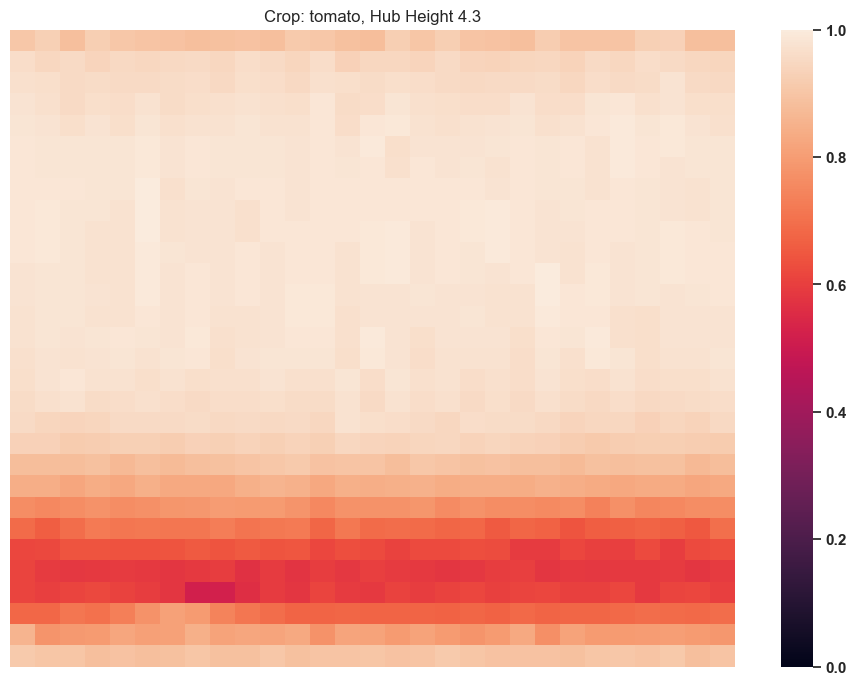

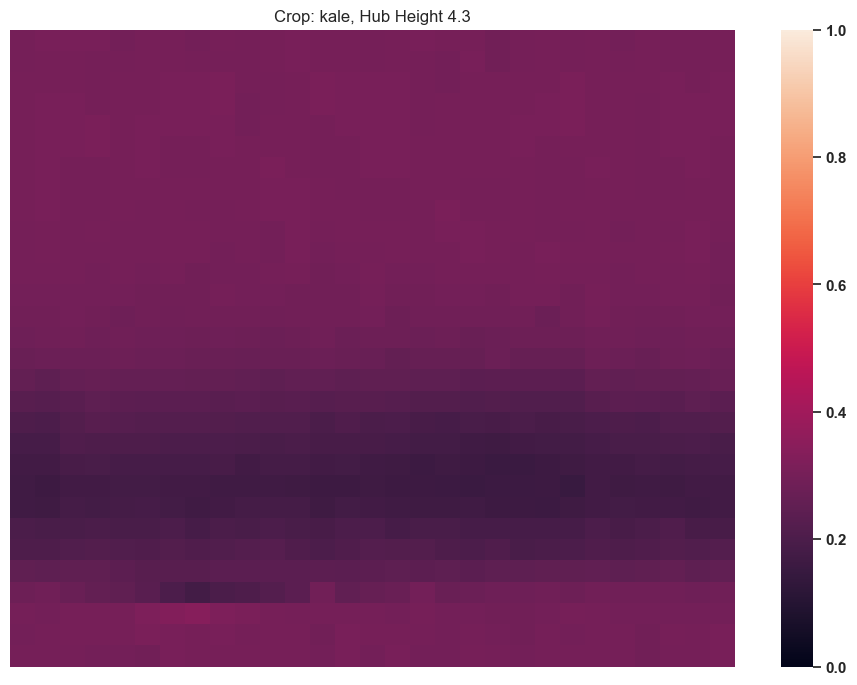

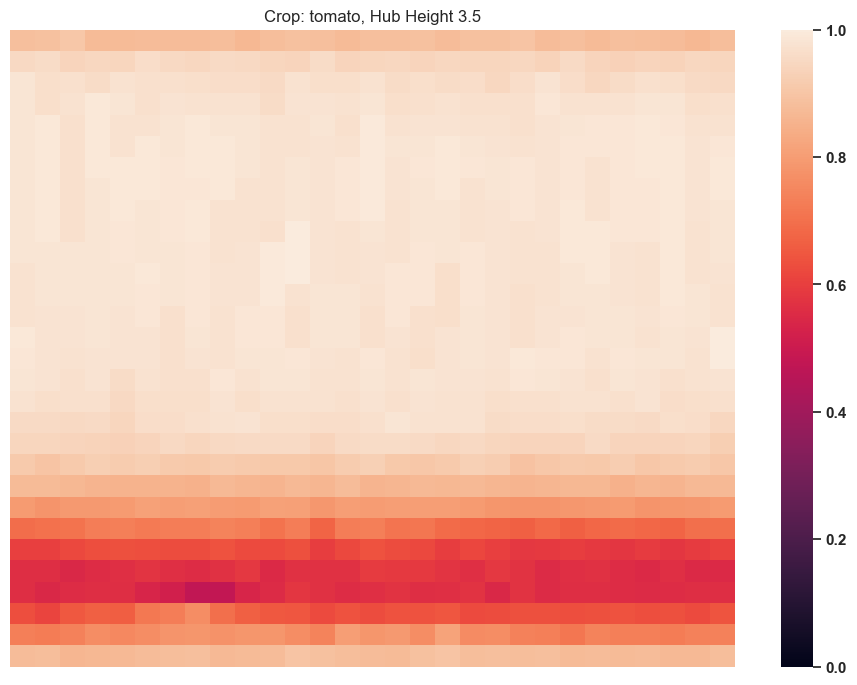

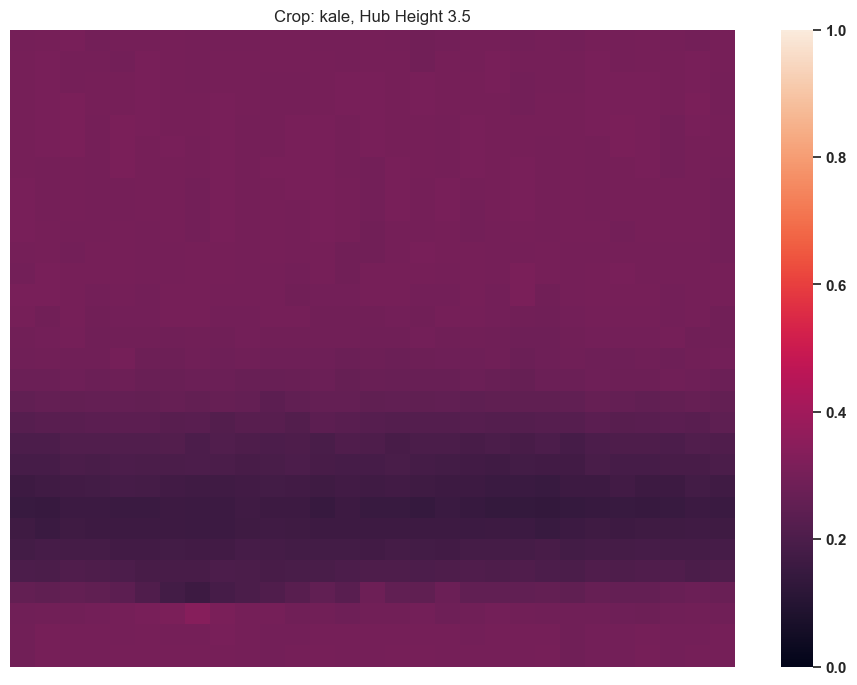

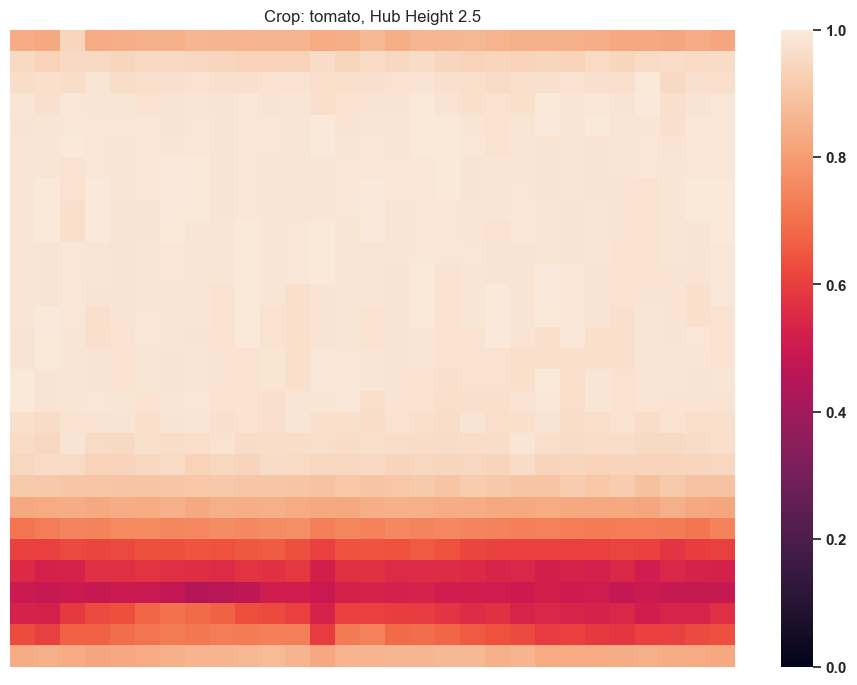

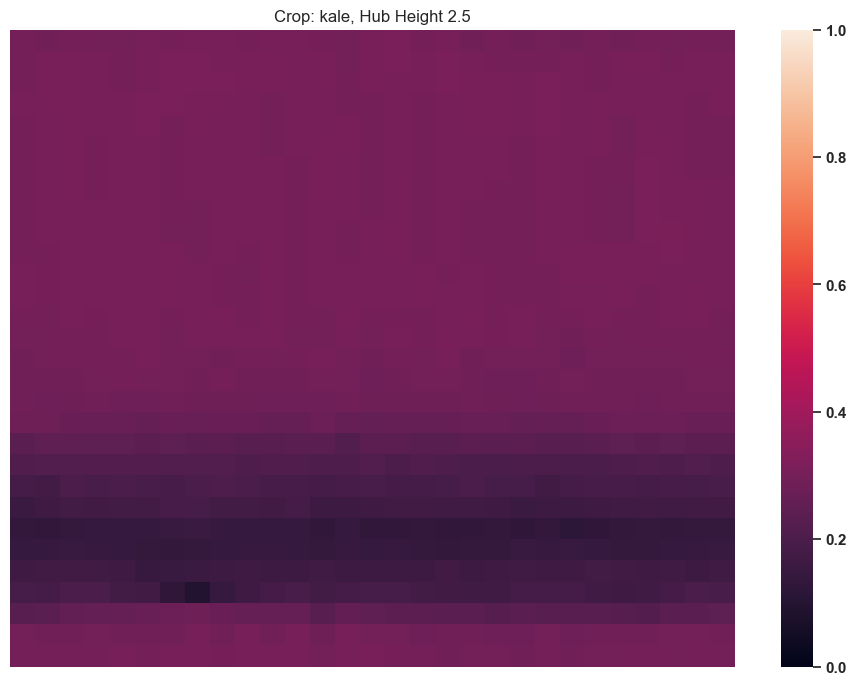

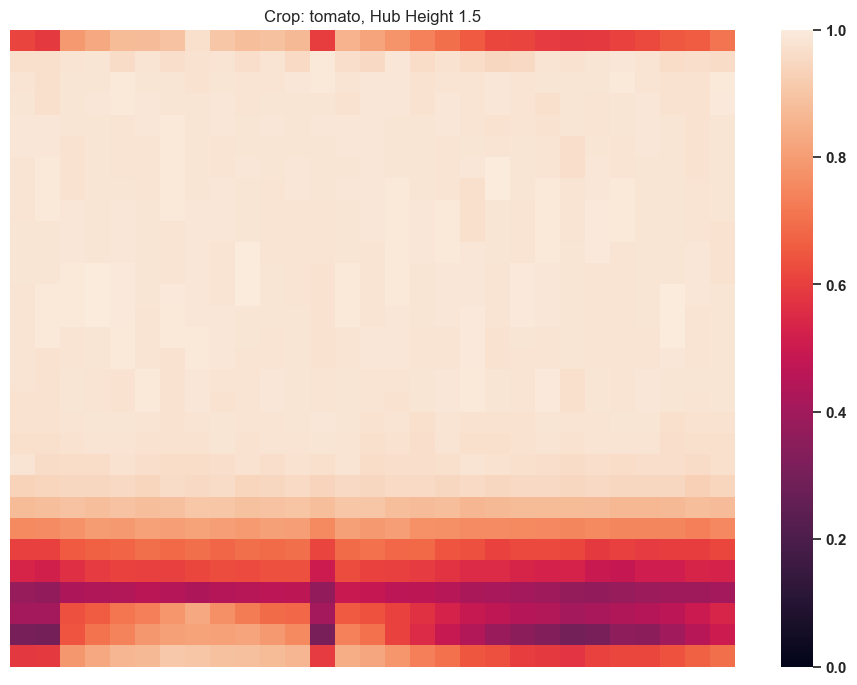

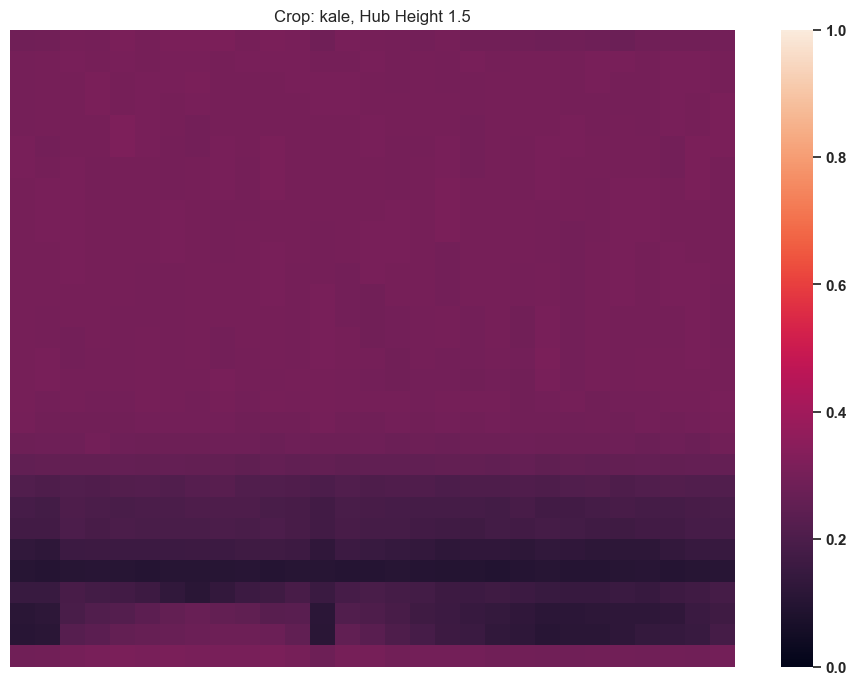

In [10]:
for hh in range (0, len(hub_heights)):
    for cc in range (0, len(crops)):
        filestarter = "irr_height_"+ str(int(hub_heights[hh]*100))+'cm_'+crops[cc]

        filelist = sorted(os.listdir(os.path.join(testfolder, 'results')))
        prefixed = [filename for filename in filelist if filename.startswith(filestarter)]
        arrayWm2Front = []
        arrayWm2Back = []
        arrayMatFront = []
        arrayMatBack = []
        filenamed = []
        faillist = []

        i = 0  # counter to track # files loaded.

        for i in range (0, len(prefixed)-1):
            ind = prefixed[i].split('_')
            #print(" Working on ", filelist[i], locs[ii], Scenario[jj])
            try:
                resultsDF = load.read1Result(os.path.join(testfolder, 'results', prefixed[i]))
                arrayWm2Front.append(list(resultsDF['Wm2Front']))
                arrayWm2Back.append(list(resultsDF['Wm2Back']))
                arrayMatFront.append(list(resultsDF['mattype']))
                arrayMatBack.append(list(resultsDF['rearMat']))
                filenamed.append(prefixed[i])
            except:
                print(" FAILED ", i, prefixed[i])
                faillist.append(prefixed[i])

        resultsdf = pd.DataFrame(list(zip(arrayWm2Front, arrayWm2Back, 
                                          arrayMatFront, arrayMatBack)),
                                 columns = ['br_Wm2Front', 'br_Wm2Back', 
                                            'br_MatFront', 'br_MatBack'])
        resultsdf['filename'] = filenamed
        
        df3 = pd.DataFrame(resultsdf['br_Wm2Front'].to_list())
        reversed_df = df3.T.iloc[::-1]
            
        plt.figure()
        ax = sns.heatmap(reversed_df/maxmax, vmin=0, vmax=1)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_ylabel('')  
        ax.set_xlabel('')
        mytitle = 'Crop: '+crops[cc]+', Hub Height '+str(hub_heights[hh])
        ax.set_title(mytitle)
        
        print(mytitle, "MAX irradiance", round(df3.max().max()/1000,1), " kW/m2; Min irradiance", round(df3.min().min()/1000,1), "kW/m2")

print("")